In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

import torch
from torch import nn, optim
import torch.nn.functional as F

from functions import train_model

In [2]:
DATA_PATH = "./bearing_features.csv"
R_SEAD = 19
torch.manual_seed(R_SEAD);

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


## Data

In [5]:
data = pd.read_csv(DATA_PATH)
data = data.set_index('time_key')
data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
data = data.sort_index()

In [6]:
data.head()

,bearing_1_mean,bearing_1_std,bearing_1_rms,bearing_2_mean,bearing_2_std,bearing_2_rms,bearing_3_mean,bearing_3_std,bearing_3_rms,bearing_4_mean,bearing_4_std,bearing_4_rms
time_key,,,,,,,,,,,,
2004-02-12 10:52:39,0.060236,0.076189,0.076228,0.074227,0.093707,0.093720,0.083926,0.109855,0.109864,0.044443,0.056039,0.056146
2004-02-12 11:02:39,0.061455,0.078694,0.078726,0.073844,0.092920,0.092949,0.084457,0.110620,0.110662,0.045081,0.056686,0.056808
2004-02-12 11:12:39,0.061361,0.078440,0.078475,0.075609,0.095340,0.095350,0.082837,0.107503,0.107507,0.045118,0.056778,0.056841
2004-02-12 11:22:39,0.061665,0.078296,0.078311,0.073279,0.092395,0.092404,0.084879,0.110509,0.110510,0.044172,0.055497,0.055567
2004-02-12 11:32:39,0.061944,0.078619,0.078633,0.074593,0.093907,0.093920,0.082626,0.107377,0.107390,0.044659,0.056206,0.056280


In [7]:
train = data['2004-02-12 10:52:39': '2004-02-17 12:52:39']
train, val = train_test_split(train, test_size=0.1)
test = data['2004-02-17 12:52:39':]

In [8]:
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (659, 12)
Validation dataset shape: (74, 12)
Test dataset shape: (250, 12)


In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_val = scaler.transform(val)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"

In [10]:
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [11]:
train_dataset, seq_len, n_features = create_dataset(X_train)
val_dataset, _, _ = create_dataset(X_val)
test_dataset, _, _ = create_dataset(X_test)

In [12]:
x = train_dataset[0]

In [13]:
x

tensor([[0.0409],
        [0.0338],
        [0.0337],
        [0.4331],
        [0.6593],
        [0.4373],
        [0.6396],
        [0.5668],
        [0.5680],
        [0.1229],
        [0.1240],
        [0.1240]])

## Training

### Autoencoder

In [14]:
class Autoencoder(torch.nn.Module):

    def __init__(self, n_features, embedding_dim):
        super(Autoencoder, self).__init__()
        
        self.hidden_dim = embedding_dim

        self.encoder_linear_1 = torch.nn.Linear(n_features, self.hidden_dim)
        self.encoder_linear_2 = torch.nn.Linear(self.hidden_dim, 2 * self.hidden_dim)
        self.encoder_linear_3 = torch.nn.Linear(2 * self.hidden_dim, self.hidden_dim)
        
        self.decoder_linear_1 = torch.nn.Linear(self.hidden_dim, 2 * self.hidden_dim)
        self.decoder_linear_2 = torch.nn.Linear(2 * self.hidden_dim, n_features)
        
        self.tanh = nn.Tanh()
        
        
    def encoder(self, x):
        encoded = self.encoder_linear_1(x)
        encoded = self.tanh(encoded)
        encoded = self.encoder_linear_2(encoded)
        encoded = self.tanh(encoded)
        encoded = self.encoder_linear_3(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        decoded = self.decoder_linear_1(encoded_x)
        decoded = self.tanh(decoded)
        decoded = self.decoder_linear_2(decoded)
        return decoded
        
    def forward(self, x):
        x = torch.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
model = Autoencoder(seq_len, 6)
model = model.to(device)

In [16]:
autoencoder_model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
)

Epoch 1: train loss 21.1513356930931 val loss 17.920639295835752
Epoch 2: train loss 18.206532458795945 val loss 17.622772574424744
Epoch 3: train loss 18.085245564059893 val loss 17.542038585688616
Epoch 4: train loss 18.01998396889393 val loss 17.434096346030366
Epoch 5: train loss 17.97756029622508 val loss 17.392226982761073
Epoch 6: train loss 17.962831366948546 val loss 17.391012971465653
Epoch 7: train loss 17.953935234608167 val loss 17.35835327006675
Epoch 8: train loss 17.941020142145693 val loss 17.33507752418518
Epoch 9: train loss 17.92643671404791 val loss 17.326244653882206
Epoch 10: train loss 17.907893755728992 val loss 17.3399341911883
Epoch 11: train loss 17.90851822463804 val loss 17.408088870950646
Epoch 12: train loss 17.902796834662038 val loss 17.41144481542948
Epoch 13: train loss 17.893632323680407 val loss 17.41092875197127
Epoch 14: train loss 17.902380192225547 val loss 17.379966594077445
Epoch 15: train loss 17.891695972277653 val loss 17.384015531153292
E

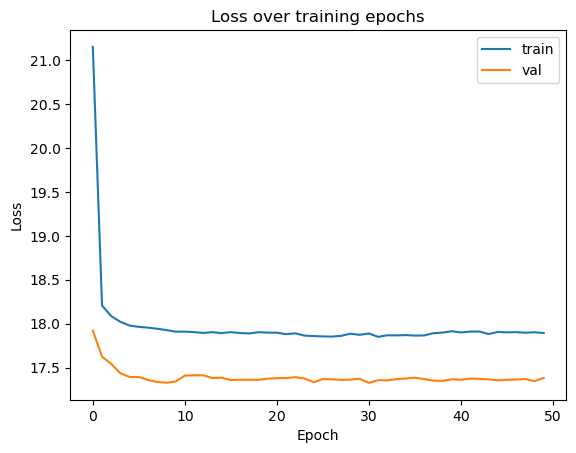

In [17]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

In [18]:
torch.save(autoencoder_model, "./models/autoencoder_model")

In [19]:
autoencoder_model = torch.load("./models/autoencoder_model")

### RNN Autoencoder

In [20]:
class RNN_Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim):
        super(RNN_Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.RNN(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
    
        self.rnn2 = nn.RNN(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, _ = self.rnn1(x)
        x, hidden_n = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [21]:
class RNN_Decoder(nn.Module):
    def __init__(self, seq_len, embedding_dim, n_features):
        super(RNN_Decoder, self).__init__()
        self.seq_len, self.embedding_dim = seq_len, embedding_dim
        self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
        self.rnn1 = nn.RNN(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
            )

        self.rnn2 = nn.RNN(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
            )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.embedding_dim))

        x, hidden_n = self.rnn1(x)
        x, hidden_n = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [22]:
class RNN_Autoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim):
        super(RNN_Autoencoder, self).__init__()

        self.encoder = RNN_Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = RNN_Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [23]:
rnn_model = RNN_Autoencoder(seq_len, n_features, 32)
rnn_model = rnn_model.to(device)

In [24]:
rnn_model, history = train_model(
  rnn_model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
)

Epoch 1: train loss 0.9329420841088425 val loss 0.4986687874471819
Epoch 2: train loss 0.5703741149222181 val loss 0.46651129666212443
Epoch 3: train loss 0.47984695822362294 val loss 0.5697519924189594
Epoch 4: train loss 0.45746345016455253 val loss 0.4583606570959091
Epoch 5: train loss 0.4371447875892266 val loss 0.46345241045629654
Epoch 6: train loss 0.42949934616933644 val loss 0.38886945553728053
Epoch 7: train loss 0.39119327637015056 val loss 0.34327123455099157
Epoch 8: train loss 0.3686934998753581 val loss 0.3136387090827968
Epoch 9: train loss 0.3611176033731838 val loss 0.4249251219066414
Epoch 10: train loss 0.34140251634560514 val loss 0.3630861064066758
Epoch 11: train loss 0.3479845018008772 val loss 0.30937197260759974
Epoch 12: train loss 0.3415967493412708 val loss 0.3456420397033563
Epoch 13: train loss 0.3164735711398725 val loss 0.3191546045646474
Epoch 14: train loss 0.3156055315752402 val loss 0.3579688350091109
Epoch 15: train loss 0.3268200663541626 val los

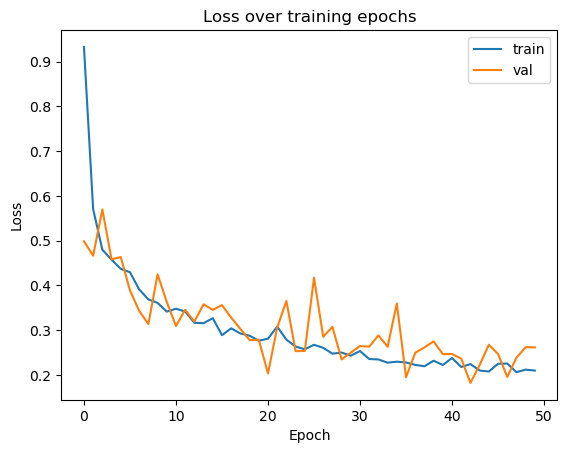

In [25]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

### LSTM Autoencoder

In [26]:
class LSTM_Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTM_Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
    
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [27]:
class LSTM_Decoder(nn.Module):
    def __init__(self, seq_len, embedding_dim, n_features):
        super(LSTM_Decoder, self).__init__()
        self.seq_len, self.embedding_dim = seq_len, embedding_dim
        self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
            )

        self.rnn2 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
            )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.embedding_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [28]:
class LSTM_Autoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTM_Autoencoder, self).__init__()

        self.encoder = LSTM_Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = LSTM_Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [29]:
lstm_model = LSTM_Autoencoder(seq_len, n_features, 32)
lstm_model = lstm_model.to(device)

In [30]:
lstm_model, history = train_model(
  lstm_model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
)

Epoch 1: train loss 1.3031808661130202 val loss 1.0885834246873856
Epoch 2: train loss 1.0462974867075456 val loss 0.9506243253881866
Epoch 3: train loss 0.8912355133723778 val loss 0.7634727326599328
Epoch 4: train loss 0.7016233496130507 val loss 0.6282694661939466
Epoch 5: train loss 0.5706766664710501 val loss 0.5576402842998505
Epoch 6: train loss 0.4863228887229118 val loss 0.4013010350030822
Epoch 7: train loss 0.4239264108319746 val loss 0.3484425893103754
Epoch 8: train loss 0.40161895514529466 val loss 0.36682157399686605
Epoch 9: train loss 0.3742842408227812 val loss 0.40041606671906804
Epoch 10: train loss 0.3465787586678323 val loss 0.3705292615938831
Epoch 11: train loss 0.32461684392779294 val loss 0.3470336770689165
Epoch 12: train loss 0.29551279385417295 val loss 0.3485657806332047
Epoch 13: train loss 0.27841996300925975 val loss 0.2766135858522879
Epoch 14: train loss 0.2532719535603328 val loss 0.35728137738801335
Epoch 15: train loss 0.24757136485916711 val loss 

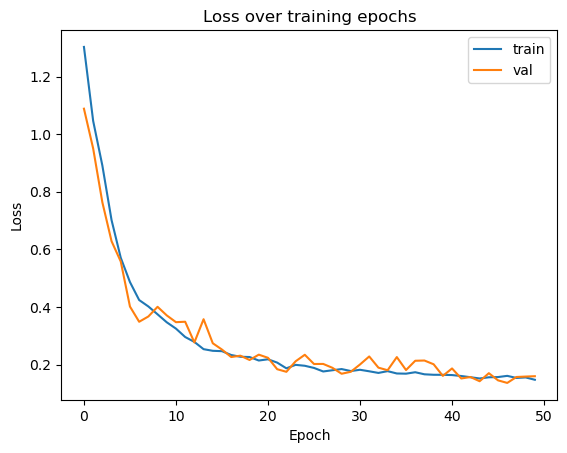

In [31]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

## Inference

In [32]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

### Normal

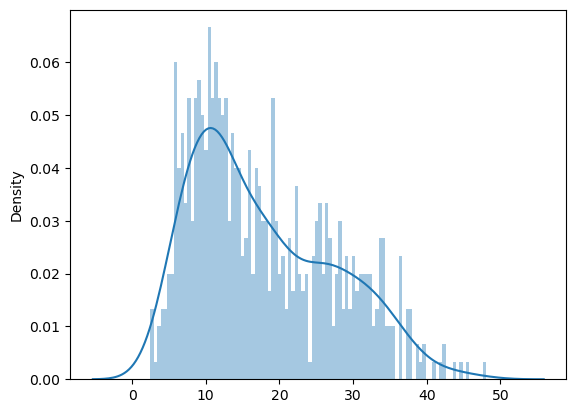

In [33]:
predictions, losses = predict(model, train_dataset)

sns.distplot(losses, bins=100, kde=True);

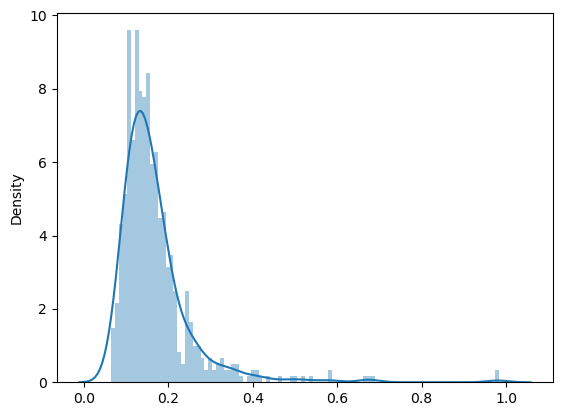

In [34]:
predictions, losses = predict(rnn_model, train_dataset)

sns.distplot(losses, bins=100, kde=True);

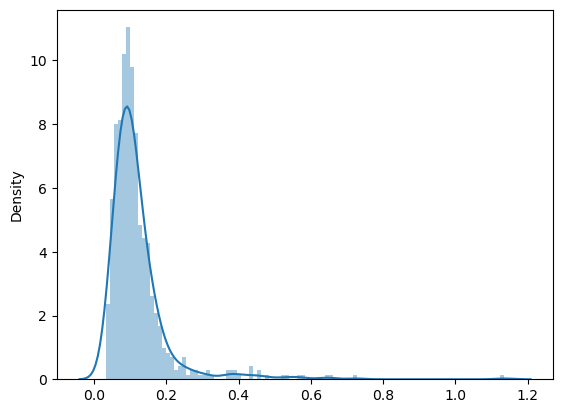

In [35]:
predictions, losses = predict(lstm_model, train_dataset)

sns.distplot(losses, bins=100, kde=True);

### Anomalies

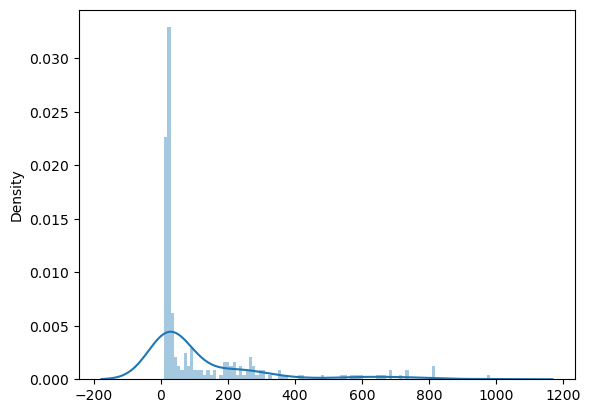

In [36]:
predictions, pred_losses = predict(model, test_dataset)
sns.distplot(pred_losses, bins=100, kde=True);

In [52]:
correct = sum(l > 50 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_dataset)}')

Correct anomaly predictions: 18/250


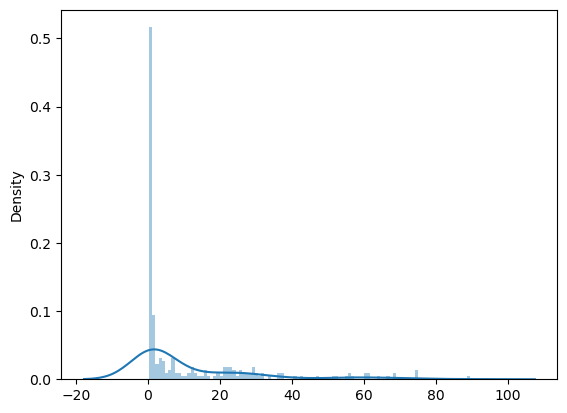

In [44]:
predictions, pred_losses = predict(rnn_model, test_dataset)

sns.distplot(pred_losses, bins=100, kde=True);

In [54]:
correct = sum(l > 1 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_dataset)}')

Correct anomaly predictions: 222/250


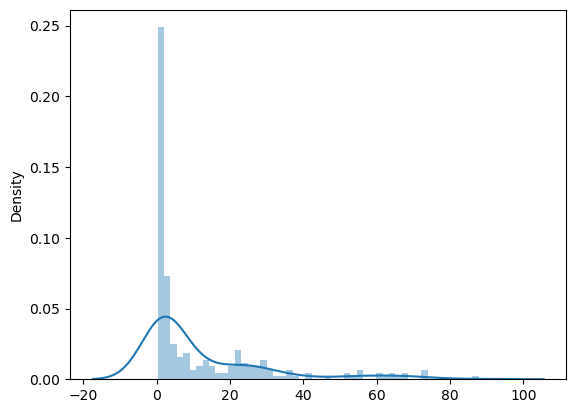

In [46]:
predictions, pred_losses = predict(lstm_model, test_dataset)

sns.distplot(pred_losses, bins=50, kde=True);

In [47]:
correct = sum(l > 1 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_dataset)}')

Correct anomaly predictions: 222/250
